In [13]:
from sys import path

import numpy as np
from numpy.random import default_rng
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

# user-written 
import w8_estimation as est 
import w8_LinearModel as lm
import w8_probit as probit
import w8_logit as logit
import marginal_effects as me

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Outcome label
y_lab = 'anyuseofforce_coded'

# Dataset columns
rawdat_columns = [
    'anyuseofforce_coded',
    
    # Subject (civilian) characteristics
    'sblack',
    'shisp',
    'snowhite',
    'smale',
    'sother', 
    'sage',
    'sempl', 
    'sincome',
    'spop', 
    'sbehavior',
    
    # Officer characteristics
    'omajblack',
    'omajhisp',
    'omajwhite',
    'omajother', 
    'osplit', 
    
    # Encounter characteristics
    'daytime',
    'inctype_lin', 
    'year'
]

In [15]:
# Final X-matrix variable labels 
x_lab = [
    # Subject vars (non-white indicator is main regressor)
    'snowhite',
    'smale',
    'sage',
    'sincome', 
    'sempl',
    'spop', 
    'inctype_lin',
    'sbehavior',

    # Officer vars
    'omajwhite',

    # Encounter vars
    'daytime'
]


In [16]:
# Helper list with the non-white indicator only
x_lab_white = ['snowhite']


In [17]:
def make_desc(df):
    out = df.describe().T[['mean', 'std']]
    out.index.name = 'Variable'
    return out

In [18]:
dat = pd.read_csv('ppcs_cc.csv')

In [19]:
dat['snowhite'] = dat['sblack'] + dat['shisp'] + dat['sother']
dat['snowhite'] = (dat['snowhite']>0).astype(float)


In [20]:
# Take all numeric variables
sub = dat.select_dtypes(include='number').copy()

# Panel A
panel_all = make_desc(sub)

# Panel B
panel_force = make_desc(sub[sub[y_lab] == 1])

summary = pd.concat(
    {'All observations': panel_all,
     'Any use of force = 1': panel_force},
    axis=1
)

summary_rounded = summary.round(3)
print(summary_rounded)

                    All observations         Any use of force = 1        
                                mean     std                 mean     std
Variable                                                                 
sblack                         0.111   0.314                0.158   0.375
shisp                          0.102   0.302                0.316   0.478
swhite                         0.739   0.439                0.474   0.513
sother                         0.049   0.215                0.053   0.229
smale                          0.530   0.499                0.789   0.419
sage                          41.010  16.147               30.789  11.193
sempl                          0.695   0.460                0.474   0.513
sincome                        2.165   0.848                2.053   0.848
spop                           1.363   0.766                1.947   1.079
daytime                        0.666   0.472                0.474   0.513
inctype_lin                    1.958  

In [21]:
def summary_to_latex(df, filename=None, caption=None, label=None):
    """
    Convert a MultiIndex-column DataFrame like your summary table
    into LaTeX without using pandas.to_latex().
    Works even when jinja2 is missing.
    """
    # Extract level names
    level_0 = df.columns.get_level_values(0)
    level_1 = df.columns.get_level_values(1)

    # Unique panel names (Panel A, Panel B)
    panels = list(dict.fromkeys(level_0))

    # Build LaTeX lines
    lines = []
    lines.append(r"\begin{table}[htbp]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabular}{l" + "r" * len(df.columns) + "}")
    lines.append(r"\hline")
    
    # First header row: panel names
    header1 = [""]  # first empty cell (for row index)
    for p in panels:
        count = sum(level_0 == p)
        header1.append(r"\multicolumn{" + str(count) + r"}{c}{" + p + r"}")
    lines.append(" & ".join(header1) + r" \\")
    
    # Second header row: statistic names (mean, std, min, max)
    header2 = ["Variable"]
    header2 += list(level_1)
    lines.append(" & ".join(header2) + r" \\")
    lines.append(r"\hline")
    
    # Data rows
    for idx, row in df.iterrows():
        row_vals = [idx] + [f"{v:.3f}" for v in row]
        lines.append(" & ".join(row_vals) + r" \\")
    
    lines.append(r"\hline")
    lines.append(r"\end{tabular}")

    if caption:
        lines.append(r"\caption{" + caption + r"}")
    if label:
        lines.append(r"\label{" + label + r"}")

    lines.append(r"\end{table}")

    latex_str = "\n".join(lines)

    if filename is not None:
        with open(filename, "w") as f:
            f.write(latex_str)

    return latex_str

In [22]:
latex_code = summary_to_latex(
    summary_rounded,
    filename="descriptive_table.tex",
    caption="Descriptive statistics",
    label="tab:desc_stats"
)

print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{lrrrr}
\hline
 & \multicolumn{2}{c}{All observations} & \multicolumn{2}{c}{Any use of force = 1} \\
Variable & mean & std & mean & std \\
\hline
sblack & 0.111 & 0.314 & 0.158 & 0.375 \\
shisp & 0.102 & 0.302 & 0.316 & 0.478 \\
swhite & 0.739 & 0.439 & 0.474 & 0.513 \\
sother & 0.049 & 0.215 & 0.053 & 0.229 \\
smale & 0.530 & 0.499 & 0.789 & 0.419 \\
sage & 41.010 & 16.147 & 30.789 & 11.193 \\
sempl & 0.695 & 0.460 & 0.474 & 0.513 \\
sincome & 2.165 & 0.848 & 2.053 & 0.848 \\
spop & 1.363 & 0.766 & 1.947 & 1.079 \\
daytime & 0.666 & 0.472 & 0.474 & 0.513 \\
inctype_lin & 1.958 & 0.200 & 1.684 & 0.478 \\
omajblack & 0.061 & 0.239 & 0.000 & 0.000 \\
omajhisp & 0.024 & 0.153 & 0.053 & 0.229 \\
omajwhite & 0.904 & 0.295 & 0.947 & 0.229 \\
omajother & 0.012 & 0.107 & 0.000 & 0.000 \\
osplit & 0.000 & 0.000 & 0.000 & 0.000 \\
sbehavior & 0.065 & 0.247 & 0.526 & 0.513 \\
year & 2011.000 & 0.000 & 2011.000 & 0.000 \\
anyuseofforce_coded & 0.005 & 

In [23]:
# Use the existing dat and ensure 'snowhite' is available before reordering
if 'snowhite' not in dat.columns:
	dat['snowhite'] = (dat['sblack'] + dat['shisp'] + dat['sother'] > 0).astype(float)

N = dat.shape[0]

# reorder columns 
dat = dat[[y_lab] + x_lab].copy()

dat.head(5)

assert dat.notnull().all(axis=1).all(), 'Missings in the dataset, take them out!'

In [24]:
y = dat[y_lab].values
x = dat[x_lab].values
K = x.shape[1]

print("Shape x:", x.shape)
print("Rank x:", np.linalg.matrix_rank(x))
y.shape

Shape x: (3799, 10)
Rank x: 10


(3799,)

In [25]:
# OLS estimates
ols_results = lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_lab, x_lab), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: anyuseofforce_coded

R2 = 0.028
sigma2 = nan


,b_hat,se,t
snowhite,0.0053,0.0036,1.4769
smale,0.0055,0.0022,2.4606
sage,-0.0001,0.0001,-1.5941
sincome,0.0019,0.0014,1.3571
sempl,-0.0049,0.0032,-1.5532
spop,0.0055,0.0023,2.3724
inctype_lin,-0.0073,0.0043,-1.7015
sbehavior,0.0371,0.0124,2.9910
omajwhite,0.0100,0.0038,2.6464
daytime,-0.0015,0.0029,-0.5059


In [26]:
theta0 = probit.starting_values(y, x)
theta0.ndim==1

True

In [27]:
ll = probit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll), -1.0411283428047824)

False

In [28]:
#probit_results = est.estimate(probit.q, theta0, y, x)

In [29]:
#probit_tab = est.print_table(x_lab, probit_results, title=f'Probit, y = {y_lab}')
#probit_tab

In [30]:
theta0 = logit.starting_values(y, x)
theta0 

array([ 0.02124792,  0.02204603, -0.00041299,  0.00771517, -0.01971493,
        0.02210033, -0.02919758,  0.1485243 ,  0.04014989, -0.00580328])

In [31]:
ll = logit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll),-0.9974267061091704)

False

In [32]:
logit_results = est.estimate(logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023897
         Iterations: 56
         Function evaluations: 869
         Gradient evaluations: 79


In [33]:
logit_tab = est.print_table(x_lab, logit_results, title=f'Logit, y = {y_lab}')
logit_tab

Optimizer succeeded after 56 iter. (869 func. evals.). Final criterion:   0.0239.
Logit, y = anyuseofforce_coded


,theta,se,t
snowhite,0.2869,0.5849,0.4905
smale,0.7567,0.7668,0.9869
sage,-0.0498,0.0264,-1.8865
sincome,-0.1220,0.3049,-0.4001
sempl,-0.8751,0.5541,-1.5792
spop,0.3548,0.3004,1.1811
inctype_lin,-2.2686,0.7075,-3.2064
sbehavior,2.3859,0.5902,4.0426
omajwhite,-0.0719,1.2959,-0.0555
daytime,-0.4101,0.5399,-0.7597


In [34]:
# Reference covariate profile used for marginal effects (set to sample averages)
x_ref = dat[x_lab].mean().values.astype(float)
pd.DataFrame(x_ref.reshape(1, -1), columns=x_lab, index=['x_ref'])


,snowhite,smale,sage,sincome,sempl,spop,inctype_lin,sbehavior,omajwhite,daytime
x_ref,0.260858,0.529613,41.010003,2.16478,0.695446,1.362727,1.95841,0.065017,0.903659,0.666491


In [35]:
# Delta-method partial effects for logit across all regressors
b_lg = logit_results['theta']
cov_lg = logit_results['cov']

binary_vars = ['snowhite', 'smale', 'sempl', 'sbehavior', 'omajwhite', 'daytime']
continuous_vars = ['sage', 'sincome', 'spop', 'inctype_lin']
all_vars = binary_vars + continuous_vars

me_rows = []

for var in binary_vars:
    idx = x_lab.index(var)
    x0 = x_ref.copy()
    x1 = x_ref.copy()
    x0[idx] = 0.0
    x1[idx] = 1.0
    effect, se = me.discrete_effect_delta(b_lg, cov_lg, x0, x1, logit.G)
    me_rows.append({
        'Var': var,
        'Effect (LPM)': ols_results['b_hat'][idx],
        's.e. (LPM)': ols_results['se'][idx],
        'Effect (Logit)': effect,
        's.e. (Logit)': se,
    })

for var in continuous_vars:
    idx = x_lab.index(var)
    effect, se = me.continuous_effect_delta(b_lg, cov_lg, x_ref, idx, logit.Gprime)
    me_rows.append({
        'Var': var,
        'Effect (LPM)': ols_results['b_hat'][idx],
        's.e. (LPM)': ols_results['se'][idx],
        'Effect (Logit)': effect,
        's.e. (Logit)': se,
    })

me_tab = pd.DataFrame(me_rows).set_index('Var')
me_tab['t (LPM)'] = me_tab['Effect (LPM)'] / me_tab['s.e. (LPM)']
me_tab['t (Logit)'] = me_tab['Effect (Logit)'] / me_tab['s.e. (Logit)']

In [36]:
me_tab.round(4)

,Effect (LPM),s.e. (LPM),Effect (Logit),s.e. (Logit),t (LPM),t (Logit)
Var,,,,,,
snowhite,0.0053,0.0036,0.0004,0.0010,1.4769,0.4458
smale,0.0055,0.0022,0.0010,0.0009,2.4606,1.1956
sempl,-0.0049,0.0032,-0.0015,0.0011,-1.5532,-1.3319
sbehavior,0.0371,0.0124,0.0116,0.0077,2.9910,1.4919
omajwhite,0.0100,0.0038,-0.0001,0.0019,2.6464,-0.0536
daytime,-0.0015,0.0029,-0.0006,0.0009,-0.5059,-0.6669
sage,-0.0001,0.0001,-0.0001,0.0000,-1.5941,-1.6254
sincome,0.0019,0.0014,-0.0002,0.0004,1.3571,-0.3835
spop,0.0055,0.0023,0.0005,0.0005,2.3724,1.0630


In [37]:
# Use the estimated logit coefficients already stored in the notebook (b_lg / logit_results['theta'])
X = dat[x_lab].to_numpy()
beta_hat = b_lg.copy()  # use b_lg (or use logit_results['theta'])

# linear index
xb = X @ beta_hat

# predicted probabilities (logit)
P = 1 / (1 + np.exp(-xb))

# partial effects (logit formula)
PE = (P * (1 - P))[:, None] * beta_hat[None, :]

# Average Partial Effects
APE = PE.mean(axis=0)

print("Average Partial Effects (APE):")
for name, val in zip(x_lab, APE):
    print(f"{name:15s}: {val:.4f}")

Average Partial Effects (APE):
snowhite       : 0.0014
smale          : 0.0037
sage           : -0.0002
sincome        : -0.0006
sempl          : -0.0042
spop           : 0.0017
inctype_lin    : -0.0110
sbehavior      : 0.0115
omajwhite      : -0.0003
daytime        : -0.0020


In [38]:
def compute_partial_effects(theta, x_point, binary_vars, continuous_vars):
    x_point = np.asarray(x_point, dtype=float).flatten()
    effects = {}
    for var in binary_vars:
        idx = x_lab.index(var)
        x0 = x_point.copy()
        x1 = x_point.copy()
        x0[idx] = 0.0
        x1[idx] = 1.0
        effects[var] = me.discrete_effect(theta, x0, x1, logit.G)
    for var in continuous_vars:
        idx = x_lab.index(var)
        effects[var] = me.continuous_effect(theta, x_point, idx, logit.Gprime)
    return effects


def estimate_and_compute_partial_effects(y, x, x_point, theta_start, binary_vars, continuous_vars, disp=False):
    """Estimate logit and return partial effects evaluated at x_point."""
    theta_start = np.asarray(theta_start, dtype=float)
    res = est.estimate(logit.q, theta_start, y, x, options={'disp': disp})
    effects = compute_partial_effects(res['theta'], x_point, binary_vars, continuous_vars)
    return effects, res


def bootstrap_sample(y, x, rng):
    """Draw a bootstrap resample of rows from (y, x)."""
    N = y.size
    idx = rng.integers(0, N, size=N)
    return y[idx], x[idx]

In [39]:
point_effects = compute_partial_effects(b_lg, x_ref, binary_vars, continuous_vars)
pd.Series(point_effects).reindex(all_vars).to_frame('Partial effect').round(4)


,Partial effect
snowhite,0.0004
smale,0.0010
sempl,-0.0015
sbehavior,0.0116
omajwhite,-0.0001
daytime,-0.0006
sage,-0.0001
sincome,-0.0002
spop,0.0005
inctype_lin,-0.0031


In [40]:
nboot = 200  # increase for final results
rng = default_rng(42)

theta_guess = b_lg.copy()
me_boot = np.empty((nboot, len(all_vars)))

for i in range(nboot):
    print(f'Bootstrap iteration {i+1}/{nboot}')
    y_i, x_i = bootstrap_sample(y, x, rng)
    effects_i, res_i = estimate_and_compute_partial_effects(
        y_i, x_i, x_ref, theta_guess, binary_vars, continuous_vars, disp=False)
    me_boot[i, :] = [effects_i[var] for var in all_vars]
    theta_guess = res_i['theta']

me_boot = pd.DataFrame(me_boot, columns=all_vars)
me_boot.head()

Bootstrap iteration 1/200
Bootstrap iteration 2/200
Bootstrap iteration 3/200
Bootstrap iteration 4/200
Bootstrap iteration 5/200
Bootstrap iteration 6/200
Bootstrap iteration 7/200
Bootstrap iteration 8/200
Bootstrap iteration 9/200
Bootstrap iteration 10/200
Bootstrap iteration 11/200
Bootstrap iteration 12/200
Bootstrap iteration 13/200
Bootstrap iteration 14/200
Bootstrap iteration 15/200
Bootstrap iteration 16/200
Bootstrap iteration 17/200
Bootstrap iteration 18/200
Bootstrap iteration 19/200
Bootstrap iteration 20/200
Bootstrap iteration 21/200
Bootstrap iteration 22/200
Bootstrap iteration 23/200
Bootstrap iteration 24/200
Bootstrap iteration 25/200
Bootstrap iteration 26/200
Bootstrap iteration 27/200
Bootstrap iteration 28/200
Bootstrap iteration 29/200
Bootstrap iteration 30/200
Bootstrap iteration 31/200
Bootstrap iteration 32/200
Bootstrap iteration 33/200
Bootstrap iteration 34/200
Bootstrap iteration 35/200
Bootstrap iteration 36/200
Bootstrap iteration 37/200
Bootstrap 

,snowhite,smale,sempl,sbehavior,omajwhite,daytime,sage,sincome,spop,inctype_lin
0,0.000599,-0.000178,-0.001637,0.008048,0.000219,-0.000104,-0.000056,0.000149,0.000408,-0.002575
1,0.001425,0.000340,-0.002327,0.006473,0.000116,-0.000960,-0.000068,-0.000162,0.000690,-0.003146
2,-0.000607,0.000793,-0.001995,0.011731,-0.000550,0.000255,-0.000060,-0.000433,0.000852,-0.003110
3,-0.000055,-0.000197,-0.001187,0.011179,-0.000240,-0.000947,-0.000061,0.000234,0.000220,-0.001247
4,-0.000870,0.002090,-0.001590,0.007905,-0.001377,-0.000368,-0.000092,-0.000790,0.000773,-0.003550


Text(0.5, 1.0, 'Bootstrap distribution of marginal effect')

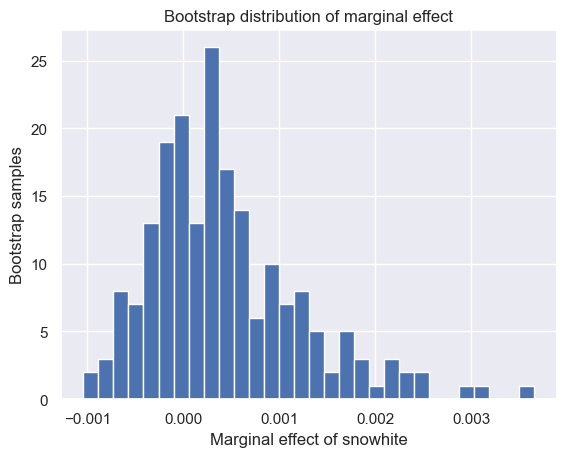

In [41]:
focus_var = 'snowhite'
plt.hist(me_boot[focus_var], bins=30)
plt.xlabel(f'Marginal effect of {focus_var}')
plt.ylabel('Bootstrap samples')
plt.title('Bootstrap distribution of marginal effect')

In [42]:
def summarize_bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    mean = df.mean()
    se = df.std(ddof=1)
    return pd.DataFrame({
        'Mean m.e.': mean,
        'Std. err.': se,
        '-1.96 se': mean - 1.96 * se,
        '+1.96 se': mean + 1.96 * se,
    })

In [43]:
bootstrap_summary = summarize_bootstrap(me_boot) 

In [44]:
bootstrap_summary.round(4)

,Mean m.e.,Std. err.,-1.96 se,+1.96 se
snowhite,0.0004,0.0008,-0.0011,0.0020
smale,0.0009,0.0007,-0.0005,0.0023
sempl,-0.0014,0.0010,-0.0034,0.0006
sbehavior,0.0096,0.0045,0.0007,0.0185
omajwhite,-0.0002,0.0005,-0.0011,0.0007
daytime,-0.0005,0.0007,-0.0018,0.0008
sage,-0.0001,0.0000,-0.0001,-0.0000
sincome,-0.0001,0.0003,-0.0007,0.0005
spop,0.0003,0.0002,-0.0001,0.0008
inctype_lin,-0.0025,0.0012,-0.0049,-0.0001


In [45]:
comparison = pd.DataFrame({
    'Delta-method': me_tab['Effect (Logit)'],
    'Bootstrap mean': bootstrap_summary['Mean m.e.'],
    'Bootstrap s.e.': bootstrap_summary['Std. err.'],
})
comparison.round(4)

,Delta-method,Bootstrap mean,Bootstrap s.e.
snowhite,0.0004,0.0004,0.0008
smale,0.0010,0.0009,0.0007
sempl,-0.0015,-0.0014,0.0010
sbehavior,0.0116,0.0096,0.0045
omajwhite,-0.0001,-0.0002,0.0005
daytime,-0.0006,-0.0005,0.0007
sage,-0.0001,-0.0001,0.0000
sincome,-0.0002,-0.0001,0.0003
spop,0.0005,0.0003,0.0002
inctype_lin,-0.0031,-0.0025,0.0012


In [46]:
specs = [
    ('I', 'No controls', ['snowhite']),
    ('II', '+ Civilian demographics', ['snowhite','smale','sage','sincome','sempl','spop','sbehavior']),
    ('III', '+ Encounter details', ['snowhite','smale','sage','sincome','sempl','spop','sbehavior','inctype_lin','daytime']),
    ('IV', '+ Officer demographics', ['snowhite','smale','sage','sincome','sempl','spop','inctype_lin','sbehavior','omajwhite','daytime']),
]


In [47]:
specs = [
    ('I', 'No controls', ['snowhite']),
    ('II', '+ Civilian demographics', ['snowhite','smale','sage','sincome','sempl','spop','sbehavior']),
    ('III', '+ Encounter details', ['snowhite','smale','sage','sincome','sempl','spop','sbehavior','inctype_lin','daytime']),
    ('IV', '+ Officer demographics', ['snowhite','smale','sage','sincome','sempl','spop','inctype_lin','sbehavior','omajwhite','daytime']),
]

def panel_results(specs, nboot=200, rng_seed=123):
    rng = default_rng(rng_seed)
    results = []
    for panel, label, cols in specs:
        X = dat[cols].to_numpy()
        theta0 = logit.starting_values(y, X)
        res = est.estimate(logit.q, theta0, y, X)
        idx = cols.index('snowhite')
        x_ref = X.mean(axis=0, keepdims=True)
        x0 = x_ref.copy(); x1 = x_ref.copy()
        x0[:, idx] = 0.0
        x1[:, idx] = 1.0
        pea, se_delta = me.discrete_effect_delta(res['theta'], res['cov'], x0, x1, logit.G)

        boot = np.empty(nboot)
        theta_guess = res['theta'].copy()
        for b in range(nboot):
            draw = rng.integers(0, y.size, size=y.size)
            y_b = y[draw]
            X_b = X[draw]
            boot_res = est.estimate(logit.q, theta_guess, y_b, X_b, options={'disp': False})
            theta_guess = boot_res['theta']
            boot[b] = me.discrete_effect(boot_res['theta'], x0, x1, logit.G)
        se_boot = boot.std(ddof=1)

        X1 = X.copy(); X0 = X.copy()
        X1[:, idx] = 1.0
        X0[:, idx] = 0.0
        ape = np.mean(logit.G(X1 @ res['theta']) - logit.G(X0 @ res['theta']))

        results.append({
            'Panel': panel,
            'Specification': label,
            'PEA': float(pea),
            'Delta SE (PEA)': float(se_delta),
            'Bootstrap SE (PEA)': float(se_boot),
            'APE': float(ape)
        })
    return pd.DataFrame(results)

panel_df = panel_results(specs)
panel_df



Optimization terminated successfully.
         Current function value: 0.527051
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.028636
         Iterations: 42
         Function evaluations: 520
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 0.023899
         Iterations: 52
         Function evaluations: 760
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 0.023897
         Iterations: 56
         Function evaluations: 869
         Gradient evaluations: 79


,Panel,Specification,PEA,Delta SE (PEA),Bootstrap SE (PEA),APE
0,I,No controls,-0.489903,0.003177,0.003356,-0.489903
1,II,+ Civilian demographics,0.000015,0.000386,0.000362,0.000123
2,III,+ Encounter details,0.000429,0.000943,0.000878,0.001449
3,IV,+ Officer demographics,0.000426,0.000956,0.000891,0.001431


In [48]:
var_types = {
    'snowhite': 'binary',
    'smale': 'binary',
    'sage': 'continuous',
    'sincome': 'continuous',
    'sempl': 'binary',
    'spop': 'continuous',
    'sbehavior': 'binary',
    'inctype_lin': 'continuous',
    'daytime': 'binary',
    'omajwhite': 'binary'
}
var_order = ['snowhite','smale','sage','sincome','sempl','spop','sbehavior','inctype_lin','daytime','omajwhite']
panel_ids = [panel for panel,_,_ in specs]
panel_effects = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ses_delta = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ses_boot = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ape = {}

nboot = 200
rng = default_rng(321)

for panel, label, cols in specs:
    X = dat[cols].to_numpy()
    theta0 = logit.starting_values(y, X)
    res = est.estimate(logit.q, theta0, y, X)
    x_ref_spec = X.mean(axis=0, keepdims=True)

    for j, var in enumerate(cols):
        if var_types[var] == 'binary':
            x0 = x_ref_spec.copy(); x1 = x_ref_spec.copy()
            x0[:, j] = 0.0
            x1[:, j] = 1.0
            effect, se = me.discrete_effect_delta(res['theta'], res['cov'], x0, x1, logit.G)
        else:
            effect, se = me.continuous_effect_delta(res['theta'], res['cov'], x_ref_spec, j, logit.Gprime)
        panel_effects.loc[var, panel] = effect
        panel_ses_delta.loc[var, panel] = se

    theta_guess = res['theta'].copy()
    boot_draws = np.empty((nboot, len(cols)))
    for b in range(nboot):
        sample = rng.integers(0, y.size, size=y.size)
        y_b = y[sample]
        X_b = X[sample]
        boot_res = est.estimate(logit.q, theta_guess, y_b, X_b, options={'disp': False})
        theta_guess = boot_res['theta']
        effs=[]
        for j,var in enumerate(cols):
            if var_types[var]=='binary':
                x0 = x_ref_spec.copy(); x1=x_ref_spec.copy()
                x0[:,j]=0.0; x1[:,j]=1.0
                effs.append(me.discrete_effect(boot_res['theta'], x0, x1, logit.G))
            else:
                effs.append(me.continuous_effect(boot_res['theta'], x_ref_spec, j, logit.Gprime))
        boot_draws[b,:]=effs
    panel_ses_boot.loc[cols, panel]=boot_draws.std(axis=0, ddof=1)

    j_nw = cols.index('snowhite')
    X0 = X.copy(); X1 = X.copy()
    X0[:, j_nw] = 0.0
    X1[:, j_nw] = 1.0
    panel_ape[panel] = np.mean(logit.G(X1 @ res['theta']) - logit.G(X0 @ res['theta']))

panel_effects.round(4)


Optimization terminated successfully.
         Current function value: 0.527051
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.028636
         Iterations: 42
         Function evaluations: 520
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 0.023899
         Iterations: 52
         Function evaluations: 760
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 0.023897
         Iterations: 56
         Function evaluations: 869
         Gradient evaluations: 79


,I,II,III,IV
snowhite,-0.4899,0.0000,0.0004,0.0004
smale,NaN,0.0002,0.0010,0.0010
sage,NaN,-0.0001,-0.0001,-0.0001
sincome,NaN,-0.0006,-0.0002,-0.0002
sempl,NaN,-0.0012,-0.0015,-0.0015
spop,NaN,0.0001,0.0005,0.0005
sbehavior,NaN,0.0064,0.0115,0.0116
inctype_lin,NaN,NaN,-0.0031,-0.0031
daytime,NaN,NaN,-0.0006,-0.0006
omajwhite,NaN,NaN,NaN,-0.0001


In [49]:
var_types = {
    'snowhite': 'binary',
    'smale': 'binary',
    'sage': 'continuous',
    'sincome': 'continuous',
    'sempl': 'binary',
    'spop': 'continuous',
    'sbehavior': 'binary',
    'inctype_lin': 'continuous',
    'daytime': 'binary',
    'omajwhite': 'binary'
}
var_order = ['snowhite','smale','sage','sincome','sempl','spop','sbehavior','inctype_lin','daytime','omajwhite']
panel_ids = [panel for panel,_,_ in specs]
panel_effects = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ses_delta = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ses_boot = pd.DataFrame(np.nan, index=var_order, columns=panel_ids)
panel_ape = {}

nboot = 200
rng = default_rng(321)

for panel, label, cols in specs:
    X = dat[cols].to_numpy()
    theta0 = logit.starting_values(y, X)
    res = est.estimate(logit.q, theta0, y, X)
    x_ref_spec = X.mean(axis=0, keepdims=True)

    effects_vec = []
    ses_vec = []
    for j, var in enumerate(cols):
        if var_types[var] == 'binary':
            x0 = x_ref_spec.copy(); x1 = x_ref_spec.copy()
            x0[:, j] = 0.0
            x1[:, j] = 1.0
            effect, se = me.discrete_effect_delta(res['theta'], res['cov'], x0, x1, logit.G)
        else:
            effect, se = me.continuous_effect_delta(res['theta'], res['cov'], x_ref_spec, j, logit.Gprime)
        panel_effects.loc[var, panel] = effect
        panel_ses_delta.loc[var, panel] = se
        effects_vec.append(effect)
        ses_vec.append(se)

    theta_guess = res['theta'].copy()
    boot_draws = np.empty((nboot, len(cols)))
    for b in range(nboot):
        sample = rng.integers(0, y.size, size=y.size)
        y_b = y[sample]
        X_b = X[sample]
        boot_res = est.estimate(logit.q, theta_guess, y_b, X_b, options={'disp': False})
        theta_guess = boot_res['theta']
        effs = []
        for j, var in enumerate(cols):
            if var_types[var] == 'binary':
                x0 = x_ref_spec.copy(); x1 = x_ref_spec.copy()
                x0[:, j] = 0.0
                x1[:, j] = 1.0
                effs.append(me.discrete_effect(boot_res['theta'], x0, x1, logit.G))
            else:
                effs.append(me.continuous_effect(boot_res['theta'], x_ref_spec, j, logit.Gprime))
        boot_draws[b, :] = effs
    panel_ses_boot.loc[cols, panel] = boot_draws.std(axis=0, ddof=1)

    j_white = cols.index('snowhite')
    X0 = X.copy(); X1 = X.copy()
    X0[:, j_white] = 0.0
    X1[:, j_white] = 1.0
    panel_ape[panel] = np.mean(logit.G(X1 @ res['theta']) - logit.G(X0 @ res['theta']))

panel_effects.round(4)


Optimization terminated successfully.
         Current function value: 0.527051
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.028636
         Iterations: 42
         Function evaluations: 520
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 0.023899
         Iterations: 52
         Function evaluations: 760
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 0.023897
         Iterations: 56
         Function evaluations: 869
         Gradient evaluations: 79


,I,II,III,IV
snowhite,-0.4899,0.0000,0.0004,0.0004
smale,NaN,0.0002,0.0010,0.0010
sage,NaN,-0.0001,-0.0001,-0.0001
sincome,NaN,-0.0006,-0.0002,-0.0002
sempl,NaN,-0.0012,-0.0015,-0.0015
spop,NaN,0.0001,0.0005,0.0005
sbehavior,NaN,0.0064,0.0115,0.0116
inctype_lin,NaN,NaN,-0.0031,-0.0031
daytime,NaN,NaN,-0.0006,-0.0006
omajwhite,NaN,NaN,NaN,-0.0001


In [50]:
def star_format(val, se_delta, se_boot):
    if pd.isna(val):
        return '', '', ''
    t = val / se_delta if (se_delta is not None and se_delta != 0 and not pd.isna(se_delta)) else np.nan
    if pd.isna(t):
        stars = ''
    elif abs(t) >= 2.576:
        stars = '***'
    elif abs(t) >= 1.96:
        stars = '**'
    elif abs(t) >= 1.645:
        stars = '*'
    else:
        stars = ''
    eff = f"{val:.4f}{stars}"
    se_delta_str = f"\\scriptsize{{({se_delta:.4f})}}" if not pd.isna(se_delta) else ""
    se_boot_str = f"\\scriptsize{{[{se_boot:.4f}]}}" if not pd.isna(se_boot) else ""
    return eff, se_delta_str, se_boot_str

latex_lines = [
    r"\begin{table}[htbp]",
    r"\centering",
    r"\caption{Partial Effects at the Average by Specification}",
    r"\begin{tabular}{l" + "r"*len(panel_ids) + r"}",
    r"\hline",
    "Variable & " + " & ".join(panel_ids) + r" \\",
    r"\hline"
]
for var in var_order:
    eff_row, delta_row, boot_row = [], [], []
    for panel in panel_ids:
        eff = panel_effects.loc[var, panel]
        se_delta = panel_ses_delta.loc[var, panel]
        se_boot = panel_ses_boot.loc[var, panel]
        eff_str, del_str, boot_str = star_format(eff, se_delta, se_boot)
        eff_row.append(eff_str)
        delta_row.append(del_str)
        boot_row.append(boot_str)
    latex_lines.append(var + ' & ' + ' & '.join(eff_row) + r" \\")
    latex_lines.append(' & ' + ' & '.join(delta_row) + r" \\")
    latex_lines.append(' & ' + ' & '.join(boot_row) + r" \\")
latex_lines.append('APE & ' + ' & '.join(f"{panel_ape[p]:.4f}" for p in panel_ids) + r" \\")
latex_lines.extend([
    r"\hline",
    r"\end{tabular}",
    r"\label{tab:panel_pea}",
    r"\end{table}"
])
latex_code_pea = '\n'.join(latex_lines)
print(latex_code_pea)


\begin{table}[htbp]
\centering
\caption{Partial Effects at the Average by Specification}
\begin{tabular}{lrrrr}
\hline
Variable & I & II & III & IV \\
\hline
snowhite & -0.4899*** & 0.0000 & 0.0004 & 0.0004 \\
 & \scriptsize{(0.0032)} & \scriptsize{(0.0004)} & \scriptsize{(0.0009)} & \scriptsize{(0.0010)} \\
 & \scriptsize{[0.0030]} & \scriptsize{[0.0004]} & \scriptsize{[0.0008]} & \scriptsize{[0.0009]} \\
smale &  & 0.0002 & 0.0010 & 0.0010 \\
 &  & \scriptsize{(0.0004)} & \scriptsize{(0.0008)} & \scriptsize{(0.0009)} \\
 &  & \scriptsize{[0.0003]} & \scriptsize{[0.0008]} & \scriptsize{[0.0006]} \\
sage &  & -0.0001** & -0.0001* & -0.0001 \\
 &  & \scriptsize{(0.0000)} & \scriptsize{(0.0000)} & \scriptsize{(0.0000)} \\
 &  & \scriptsize{[0.0000]} & \scriptsize{[0.0000]} & \scriptsize{[0.0000]} \\
sincome &  & -0.0006* & -0.0002 & -0.0002 \\
 &  & \scriptsize{(0.0003)} & \scriptsize{(0.0004)} & \scriptsize{(0.0004)} \\
 &  & \scriptsize{[0.0004]} & \scriptsize{[0.0003]} & \scriptsize{[